In [62]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/2_dynamic-programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import Agent, plot_values_lake

### Run locally

In [64]:
from rl_introduction.tools import Agent, plot_values_lake

### Objective
Before we go any further into RL. We solve the problem of environment and agents when the model is perfectly known (MDP).

In [65]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
env = gym.make('FrozenLake-v0')

### FrozenLake- environment
The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:
    
SFFF       (S: starting point, safe)

FHFH       (F: frozen surface, safe)

FFFH       (H: hole, fall to your doom)

HFFG       (G: goal, where the frisbee is located)

In [66]:
env.render()


SFFF
FHFH
FFFH
HFFG


There are 16 states

In [67]:
env.observation_space

Discrete(16)

And 4 action: $left [0], down[1], right[2], up[3]$

In [68]:
env.action_space

Discrete(4)

In [69]:
time_steps = 100
state = env.reset()
for _ in range(time_steps):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    if done is True:
        print('reset with state:{}, reward:{}'.format(state, reward))
        state = env.reset()
    env.render()
    #sleep(0.004)
env.close()

  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
reset with state:5, reward:0.0

SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
reset with state:7, reward:0.0

SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
reset with state:5, reward:0.0

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
reset with state:5, reward:0.0

SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
reset with state:5, reward:0.0

SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
H

# Dynamic Programming
Dynamic programming assumes that the agent has full knowledge of the MDP. 

## 1) env transition model

We are access of the transition model, $P(S_{t+1}=s'|S_t = s, A_t=a)$ and the associated reward using <b>env.P[s][a]</b>. For example, the probabilities of each possible reward and next state, if the agent is in state 1 of the gridworld and decides to go left.

In [98]:
state = 2
action = 0 #left

In [99]:
# P(s'|state,action), s', reward, done
env.P[state][action]

[(0.3333333333333333, 2, 0.0, False),
 (0.3333333333333333, 1, 0.0, False),
 (0.3333333333333333, 6, 0.0, False)]

We see here that there is a $1/3$ probability falling in the hole in state 5 (and finish the episode).

## 2) agent policy
We can add to our agent its <b>policy</b> $\pi(a|s)$. This agent policy can be deterministic or probabilistic.

In [23]:
#TODO: write your policy (ex uniformly random policy)
class MyRandomAgent(Agent):
    def __init__(self, env, is_deterministic = True):
        super().__init__(env)
        self.policy = None#complete here
        self.is_deterministic = is_deterministic
    def act(self, state):
        if self.is_deterministic:
            action = np.argmax(self.policy[state])
        else:
            action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])
        return action

In [100]:
#Done: write a uniformly random policy
class MyRandomAgent(Agent):
    def __init__(self, env, is_deterministic = True):
        super().__init__(env)
        self.policy = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.is_deterministic = is_deterministic
    def act(self, state):
        if self.is_deterministic:
            action = np.argmax(self.policy[state])
        else:
            action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])
        return action

<BarContainer object of 4 artists>

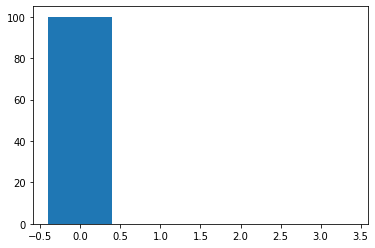

In [103]:
# test it (with random and deterministic policy)
agent = MyRandomAgent(env)#,is_deterministic = False)
nb_iter = 100
res_action = np.zeros((env.observation_space.n, env.action_space.n))
for nb in range(nb_iter):
    for state in range(env.observation_space.n):
        act = agent.act(state)
        res_action[state][act] += 1
# plot action by state (for example state 0)
plt.bar(np.arange(env.action_space.n),res_action[0])

## 2) Policy Evaluation

The Value Function $V_\pi(s)$ is the expected return in state $s$, according to $\pi$.
We know, $V_\pi(s) 
= \mathbb{E}_\pi [r + \gamma V_\pi(s_{t+1}) | S_t = s]
= \sum_a \pi(a \vert s) \sum_{s', r} P(s', r \vert s, a) (r + \gamma V_\pi(s'))$

We have all the information to resolve linear system for $V_\pi$:
\begin{equation}
V(s_0) =  \sum_a \pi(a \vert s) \sum_{s', r} P(s', r \vert s_0, a) (r + \gamma V(s'))\\
V(s_1) =  \sum_a \pi(a \vert s) \sum_{s', r} P(s', r \vert s_1, a) (r + \gamma V(s'))\\
...\\
V(s_{16}) = \sum_a \pi(a \vert s) \sum_{s', r} P(s', r \vert s_{16}, a) (r + \gamma V(s'))
\end{equation}
Even for 16 states it could be complicated. So we use an iterative approach.
We initialize $V_0$ arbitrarly. And we update it using:
$V_{k+1}(s) = \mathbb{E}_\pi [r + \gamma V_k(s_{t+1}) | S_t = s] $ (1).
$\forall s$, $V_\pi(s)$ is a fix point for (1), so if $(V_k)_{k\in \mathbb{N}}$ converges, it converges to $V_\pi$.

In [29]:
#TODO: write the value evaluation update step
def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    V = np.zeros(env.observation_space.n) # initialization
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                # action_prob is $\pi(a/s)$
                for prob, next_state, reward, done in env.P[s][a]:
                    # prob is $P(next_state, reward/s,a)$
                    Vs += None#complete here
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if delta < theta: # condition of convergence
            break
    return V

In [30]:
#Done: write the value evaluation update step
def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    V = np.zeros(env.observation_space.n) # initialization
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                # action_prob is $\pi(a/s)$
                for prob, next_state, reward, done in env.P[s][a]:
                    # prob is $P(next_state, reward/s,a)$
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if delta < theta: # condition of convergence
            break
    return V

In [104]:
my_rand_agent = MyRandomAgent(env)

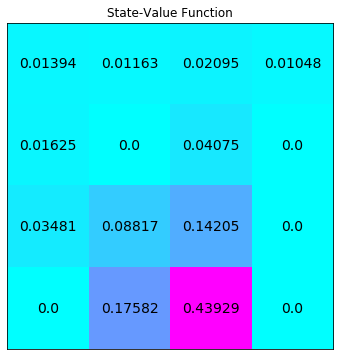

In [105]:
# evaluate the policy 
V = policy_evaluation(env, my_rand_agent.policy)

plot_values_lake(V)

In [106]:
V.sum()

0.9941411498416601

Knowing the transition $\mathbb{P}(S_{t+1},R_{t+1}|S_t,A_t)$, it is natural to compute the q function from value function.

\begin{aligned}
Q(s, a) 
&= \mathbb{E} [R_{t+1} + \gamma V(S_{t+1}) \mid S_t = s, A_t = a] \\
&= \sum_{s'} [r_{t+1} + \gamma V(s')] P(S_{t+1}=s'|S_t=s,A_t=a)
\end{aligned}

In [107]:
#TODO: write the q evaluation update step
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] +=None #TODO complete here 
    return q

In [108]:
#Done: write the q evaluation update step
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] += prob * (reward + gamma * V[next_state])
    return q

In [109]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s)
print("Action-Value Function:")
print(Q)

Action-Value Function:
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.0108613  0.01550788]
 [0.02444514 0.02095298 0.02406033 0.01435346]
 [0.01047649 0.01047649 0.00698432 0.01396865]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0.03480619 0.04640826]
 [0.07020885 0.11755991 0.10595784 0.05895312]
 [0.18940421 0.17582037 0.16001424 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799677 0.20503718 0.23442716 0.17582037]
 [0.25238823 0.53837051 0.52711478 0.43929118]
 [0.         0.         0.         0.        ]]


## 3) Policy Improvement

With the q function, we update our policy from $\pi$ to $\pi'$ by acting greedy. That means $\pi'(.|s) = \arg\max_a Q_\pi(a,s)$.

This improvment is given by: $\forall s, V_\pi(s) = \sum_a\pi(a|s)Q_\pi(s,a) \leq \max_a Q_\pi(s,a) = V_{\pi'}(s,a)$

In [112]:
#TODO: write the policy improvment update step
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        best_a = None#complete here
        policy[s] = None#complete here
        
    return policy

In [113]:
#Done: write the policy improvment update step
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
        
    return policy

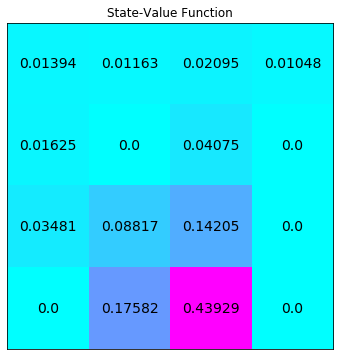

In [114]:
# evaluate the policy 
V = policy_evaluation(env, my_rand_agent.policy)

plot_values_lake(V)

In [115]:
V.sum()

0.9941411498416601

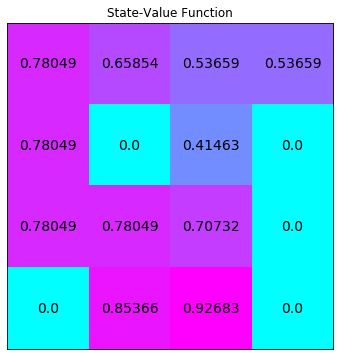

In [116]:
new_policy = policy_improvement(env, V, gamma=1)

# evaluate the policy 
new_V = policy_evaluation(env, new_policy)

plot_values_lake(new_V)

In [117]:
new_V.sum()

7.756096190590658

## 4) Policy iteration 

$\pi_0 \xrightarrow[]{\text{evaluation}} V_{\pi_0} \xrightarrow[]{\text{improve}}
\pi_1 \xrightarrow[]{\text{evaluation}} V_{\pi_1} \xrightarrow[]{\text{improve}}
\pi_2 \xrightarrow[]{\text{evaluation}} \dots \xrightarrow[]{\text{improve}}
\pi_* \xrightarrow[]{\text{evaluation}} V_*$

In [118]:
#TODO: write a condition convergence for the policy iteration
def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.nS, env.nA]) / env.nA # init a random policy
    while True:
        V = policy_evaluation(env, policy, gamma, theta)
        new_policy = policy_improvement(env, V)
        condition_stop = None # complete here
        if condition_stop:
            break;
    return policy, V

In [119]:
#Done: write a condition convergence for the policy iteration
def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        V = policy_evaluation(env, policy, gamma, theta)
        new_policy = policy_improvement(env, V)
        
        # OPTION 1: stop if the policy is unchanged after an improvement step
        if (new_policy == policy).all():
            break;
        
        # OPTION 2: stop if the value function estimates for successive policies has converged
        # if np.max(abs(policy_evaluation(env, policy) - policy_evaluation(env, new_policy))) < theta*1e2:
        #    break;
        
        policy = copy.copy(new_policy)
    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



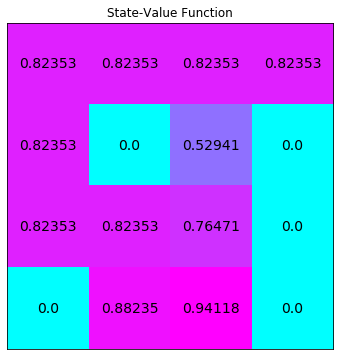

In [121]:

# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")

plot_values_lake(V_pi)

In [122]:
V_pi.sum()

8.88235133583077

## 4) Value iteration 

Value iteration consists in directly compute the best policy evaluation.
We initialize $V_0$ arbitrarly. And we update it using:

$V_{k+1}(s) = \mathbb{E}_\pi [r + \gamma \max_a Q_k(s_{t+1},a) | S_t = s] $ (2).
$\forall s$, $V_{\pi^*}(s)$ is a fix point for (2), so if $(V_k)_{k\in \mathbb{N}}$ converges, it converges to $V_{\pi^*}$.

In [54]:
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            v = V[s]
            V[s] = max(q_from_v(env, V, s, gamma))
            delta = max(delta,abs(V[s]-v))
        if delta < theta:
            break
    policy = policy_improvement(env, V, gamma)
    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



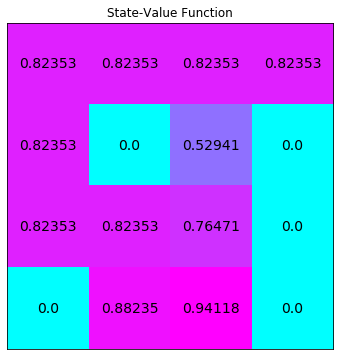

In [55]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")

# plot the optimal state-value function
plot_values_lake(V_vi)

## Train agent and Run experiments

In [123]:
class MyMDPAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
        self.policy = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def act(self, state):
        action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])
        return action
    def train(self):
        self.policy, _ = value_iteration(self.env)

In [124]:
def run_experiment_episode(env, agent, nb_episode):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            state, reward, done, info = env.step(action)
            rews.append(reward)
        rewards[i] = sum(rews)
    return rewards

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

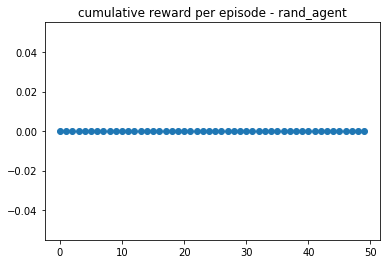

In [125]:
# compute reward with random agent
mdp_agent = MyMDPAgent(env)
rewards = run_experiment_episode(env, mdp_agent, 50)
plt.plot(rewards, 'o')
plt.title('cumulative reward per episode - rand_agent')

Text(0.5, 1.0, 'cumulative reward per episode - mdp_agent')

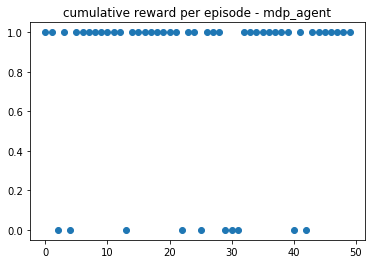

In [126]:
# compute reward after train the agent
mdp_agent.train()
rewards = run_experiment_episode(env, mdp_agent, 50)
plt.plot(rewards, 'o')
plt.title('cumulative reward per episode - mdp_agent')

In [61]:
time_steps = 100
state = env.reset()
for _ in range(time_steps):
    action = mdp_agent.act(state)
    state, reward, done, _ = env.step(action)
    if done is True:
        print('reset with state:{}, reward:{}'.format(state, reward))
        state = env.reset()
    env.render()
    #sleep(0.004)
env.close()

  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
F